In [15]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

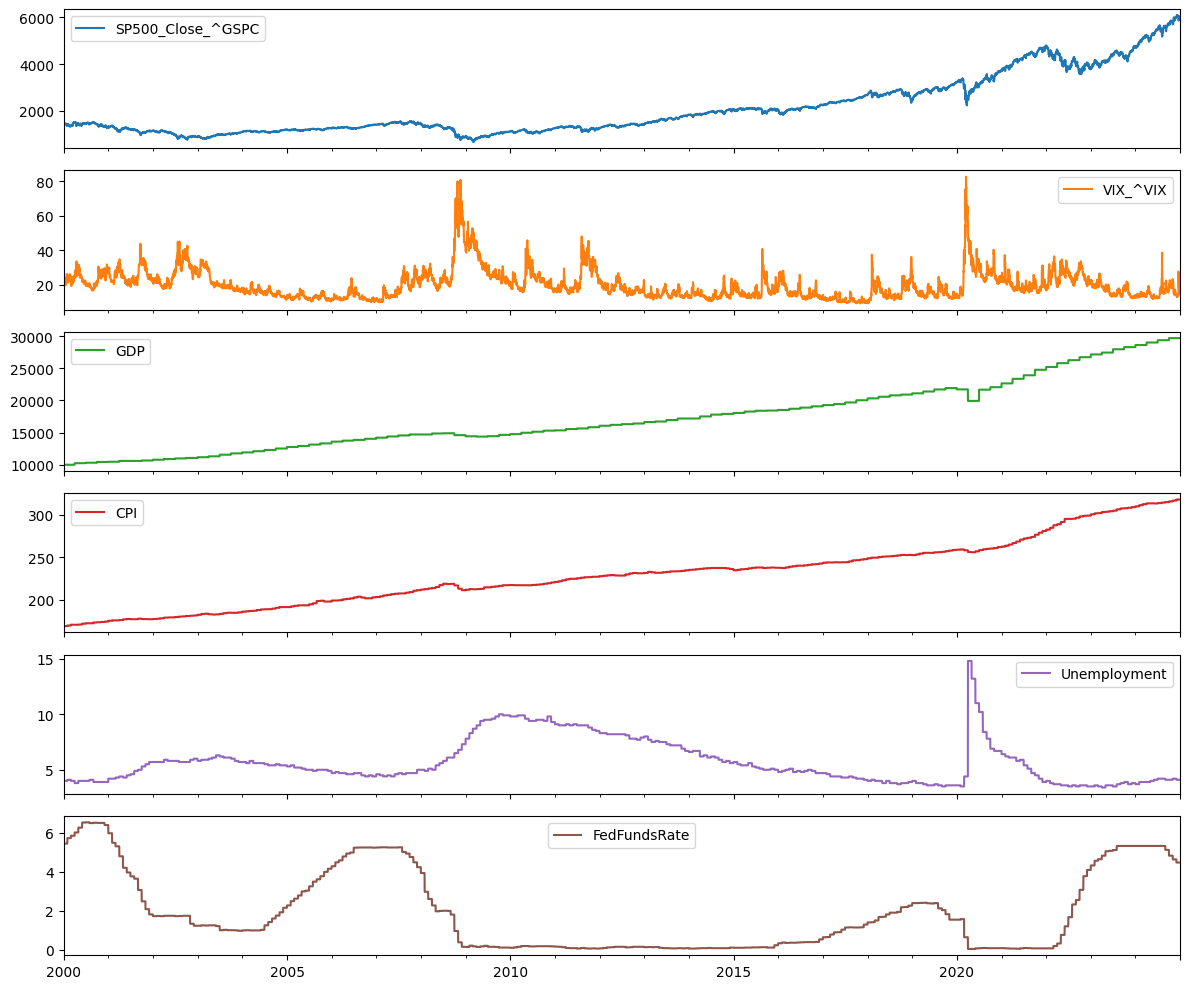

In [16]:
start_date = '2000-01-01'
end_date = '2024-12-31'

sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)[['Close']].rename(columns={'Close': 'SP500_Close'})
vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)[['Close']].rename(columns={'Close': 'VIX'})

fred_series = {'GDP': 'GDP', 'CPI': 'CPIAUCSL', 'Unemployment': 'UNRATE', 'FedFundsRate': 'FEDFUNDS'}
macro_data = {key: web.DataReader(series, 'fred', start_date, end_date) for key, series in fred_series.items()}
macro_df = pd.concat(macro_data.values(), axis=1)
macro_df.columns = macro_data.keys()
macro_df = macro_df.resample('D').ffill()
macro_df = macro_df.reindex(pd.date_range(start=macro_df.index.min(), end=sp500.index.max(), freq='D')).ffill()

sp500.index = pd.to_datetime(sp500.index)
vix.index = pd.to_datetime(vix.index)
macro_df.index = pd.to_datetime(macro_df.index)

temp_merge = sp500.merge(vix, left_index=True, right_index=True, how='outer')
temp_merge.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in temp_merge.columns]

final_merge = temp_merge.merge(macro_df, left_index=True, right_index=True, how='outer')
final_merge.ffill(inplace=True)
final_merge.bfill(inplace=True)

date_range = pd.date_range(start=final_merge.index.min(), end=final_merge.index.max(), freq='D')
missing_dates = date_range.difference(final_merge.index)

summary_stats = final_merge.describe()

final_merge[['SP500_Close_^GSPC', 'VIX_^VIX', 'GDP', 'CPI', 'Unemployment', 'FedFundsRate']].plot(subplots=True, figsize=(12, 10))
plt.tight_layout()
plt.show()

In [17]:
final_merge['SP500_EMA_7'] = final_merge['SP500_Close_^GSPC'].ewm(span=7, adjust=False).mean()
final_merge['SP500_EMA_30'] = final_merge['SP500_Close_^GSPC'].ewm(span=30, adjust=False).mean()
final_merge['GDP_EMA_30'] = final_merge['GDP'].ewm(span=30, adjust=False).mean()
final_merge['CPI_EMA_30'] = final_merge['CPI'].ewm(span=30, adjust=False).mean()
final_merge['Unemployment_EMA_30'] = final_merge['Unemployment'].ewm(span=30, adjust=False).mean()
final_merge['FedFundsRate_EMA_30'] = final_merge['FedFundsRate'].ewm(span=30, adjust=False).mean()

final_merge['SP500_Return'] = final_merge['SP500_Close_^GSPC'].pct_change()
final_merge['VIX_Lag_1'] = final_merge['VIX_^VIX'].shift(1)

final_merge['Target'] = (final_merge['SP500_EMA_7'] > final_merge['SP500_EMA_30']).astype(int)

final_merge.dropna(inplace=True)

features = [
   'SP500_EMA_30', 'VIX_^VIX', 'SP500_EMA_7',
    'GDP_EMA_30', 'CPI_EMA_30', 'Unemployment', 'FedFundsRate','VIX_Lag_1'
]

target = 'Target'

In [18]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(final_merge[features]), columns=features, index=final_merge.index)
y = final_merge[target]

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [19]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)

print(accuracy)
print(conf_matrix)
print(report)


0.8592552026286966
[[ 374  188]
 [  69 1195]]
              precision    recall  f1-score   support

           0       0.84      0.67      0.74       562
           1       0.86      0.95      0.90      1264

    accuracy                           0.86      1826
   macro avg       0.85      0.81      0.82      1826
weighted avg       0.86      0.86      0.85      1826



In [ ]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_svm)
accuracy = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm)

print(accuracy)
print(conf_matrix)
print(report)